Подгрузим и посмотрим на имеющиеся датасеты

In [ ]:
!pip install shap
!pip install lazypredict
!pip install rdkit
!pip install mordred

import numpy as np
import pandas as pd

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit import DataStructs
import sklearn
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

from rdkit import DataStructs
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Fragments
from rdkit.Chem import rdMolDescriptors
import seaborn as sns
import shap

import lazypredict
from lazypredict.Supervised import LazyRegressor

import mordred
from mordred import Calculator, descriptors

Посмотрим как выглядят датасеты.

Для всех образцов в датасете использовались наночастицы серебра Ag

Bacteria: бактериальная клетка-мишень

NP_Synthesis: тип синтеза наночастиц

drug: название лекарства

drug class: класс лекарства

Drug dose: доза препарата

NP_concentration: концентрация НЧ

NP_size: размер НЧ

shape: форма НЧ

method: метод определения антимикробной активности

ZOI_drug, ZOI_NP, ZOI_drug_NP: зона ингибирования препарата, НЧ и их комбинации

Fold increase in antibacterial activity (%): кратное увеличение

антибактериальной активности (%)

дзета-потенциал;

MDR: множественная лекарственная устойчивость резистентен ли обычный препарат к целевому патогену

Формы всех датасетов

In [ ]:
data = pd.read_csv('data.csv')
drug_descriptors = pd.read_csv(r'/content/drug_descriptors.csv')[['drug', 'smiles']]
bacterial_descriptors = pd.read_csv(r'/content/bacterial_descriptors.csv')

In [ ]:
print(data.shape)
print(bacterial_descriptors.shape)
print(drug_descriptors.shape)

(883, 18)
(59, 18)
(44, 2)


In [ ]:
pd.set_option('display.max_columns', 50)

In [ ]:
data.info()

In [ ]:
data.head(20)

In [ ]:
#Выбросим не несущие информации столбы и столбец
data = data.drop(['Unnamed: 0.1',
                  'Drug_dose',
                  'NP_concentration',
                  'fold_increase_in_antibacterial_activity (%)',],
                  axis=1)

data['ZOI_drug'][data.loc[:, 'ZOI_drug'] == '32+'] = 32
data['ZOI_drug'] = data['ZOI_drug'].astype(float)


data = data[~data.loc[:, 'Drug'].isna()]
data = data[~data.loc[:, 'ZOI_drug_NP'].isna()]




<ipython-input-63-083c3f0d3f6d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ZOI_drug'][data.loc[:, 'ZOI_drug'] == '32+'] = 32


In [ ]:
#Заменим некорректные названия бактерий

non_bacts = []
for i in data.loc[:,'Bacteria']:
   if (i == bacterial_descriptors.loc[:, 'Bacteria']).sum() == 0:
      non_bacts.append([i, (i == bacterial_descriptors.loc[:, 'Bacteria']).sum()])
np.unique(non_bacts)


array(['0', 'Acinetobacter baumanii', 'Actinobacillus pleuropneumoniae ',
       'Bacillus spp.        ', 'Candida glochares',
       'Enterobacter cloacae ', 'Salmonella  typhi',
       'Salmonella Paratyphi'], dtype='<U32')

In [ ]:
bacterial_descriptors.loc[0, 'Bacteria'] = 'Acinetobacter baumanii'
bacterial_descriptors.loc[1, 'Bacteria'] = 'Actinobacillus pleuropneumoniae '
bacterial_descriptors.loc[41, 'Bacteria'] = 'Salmonella  typhi'
bacterial_descriptors.loc[40, 'Bacteria'] = 'Bacillus spp.        '



In [ ]:
#Соеденим все в один датасет
data = data.merge(drug_descriptors, how = 'left', left_on='Drug', right_on='drug')
data = data.merge(bacterial_descriptors, how = 'left', left_on='Bacteria', right_on='Bacteria')

In [ ]:
#Выбросим слишком пустые и не несущие полезной информации столбы после объединения
data = data.drop(['subkingdom',
                  'clade' ,
                  'kingdom',
                  'phylum',
                  'class',
                  'order',
                  'family',
                  #'genus',
                  'species',
                  'Tax_id',
                  'isolated_from'
                  ],
                  axis=1)

data = data[~data.loc[:, 'smiles'].isna()]

In [ ]:
data.isna().sum()

Unnamed: 0                0
Bacteria                  0
NP_Synthesis              0
Drug                      0
Drug_class_drug_bank      0
NP size_min               0
NP size_max               0
NP size_avg               0
shape                     0
method                    0
ZOI_drug                 15
ZOI_NP                  419
ZOI_drug_NP               0
MDR_check                 0
drug                      0
smiles                    0
genus                    25
gram                     29
min_Incub_period, h      47
avg_Incub_period, h      25
max_Incub_period, h      47
growth_temp, C           25
biosafety_level          25
dtype: int64

In [ ]:
#Заменим по каждому антибиотику пропущенные значения на среднее для этого антибиотика ZOI_drug
for i in np.unique(data[data.loc[:, 'ZOI_drug'] != data.loc[:, 'ZOI_drug']].loc[:, 'Drug']):
  iter = data[data.loc[:, 'Drug'] == i].loc[:, 'ZOI_drug']

  mean = np.mean(data[data.loc[:, 'Drug'] == i].loc[:, 'ZOI_drug'])
  index = (iter[iter.isna()].index)
  if (mean == mean):
    data.loc[index, 'ZOI_drug'] = mean
  else:
    data.loc[index, 'ZOI_drug'] = np.mean(data.loc[:, 'ZOI_drug'])

In [ ]:
#Функция заменяет названия на инты и приписывает названия

def names_to_class(data):
  data1 = data
  for i in data1.columns:
    uniqs = np.unique(data1[i])

    print(i)
    print(pd.DataFrame(uniqs))

    counter = -1
    for j in uniqs:
      counter += 1
      data[i][data1[i] == j] = counter

  return data1


#data1 = names_to_class(data.loc[:, ['Bacteria', 'NP_Synthesis', 'Drug', 'Drug_class_drug_bank', 'shape', 'method']])

Заполнение ZOI_NP

In [ ]:
corr = data.loc[:, ['method', 'shape', 'NP_Synthesis', 'NP size_min', 'NP size_max', 'NP size_avg', 'ZOI_NP']].dropna(axis=0, how='any')
corr.loc[:, 'ZOI_NP'][corr.loc[:, 'ZOI_NP'] == '50+'] = 50
corr.loc[:, 'ZOI_NP'] = corr.loc[:, 'ZOI_NP'].astype(float)

<ipython-input-71-56bda5b03ed3>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  corr.loc[:, 'ZOI_NP'] = corr.loc[:, 'ZOI_NP'].astype(float)


In [ ]:
corr.loc[:, ['method',	'shape',	'NP_Synthesis']] = names_to_class(corr.loc[:, ['method',	'shape',	'NP_Synthesis']])

method
                0
0             MIC
1  disc_diffusion
2  well_diffusion
shape
           0
0  spherical
NP_Synthesis
                                                   0
0              chem_synthesis_reduction_by_D_maltose
1                   green_synthesis  by Bacillus sp.
2    green_synthesis from fungus  Aspergillus flavus
3  green_synthesis from fungus  Phytophthora infe...
4  green_synthesis using C. zylinicum aqueous ext...
5  green_synthesis using Withania coagulans fruit...
6  green_synthesis using extract of Klebsiella pn...
7  green_synthesis using extract of acinetobacter...


In [ ]:
sum = 0
n = 30
for i in range(n):
  x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(corr.iloc[:, :-1], corr.iloc[:, -1], test_size=0.3)
  rg = RandomForestRegressor(max_depth=4, n_estimators=100)
  rg.fit(x_train, y_train)
  sum += sklearn.metrics.r2_score(y_test, rg.predict(x_test))
print('R2 =', sum/n)

R2 = 0.31566461377532024


In [ ]:
zoi_np_df = data.loc[:, ['Unnamed: 0', 'method', 'shape', 'NP_Synthesis', 'NP size_min', 'NP size_max', 'NP size_avg', 'ZOI_NP']][data.loc[:, ['Unnamed: 0', 'method', 'shape', 'NP_Synthesis', 'NP size_min', 'NP size_max', 'NP size_avg']][~data.loc[:, ['Unnamed: 0', 'method', 'shape', 'NP_Synthesis', 'NP size_min', 'NP size_max', 'NP size_avg']].isna()][data.loc[:, ['ZOI_NP']].isna()].isna()]
zoi_np_df.loc[:, ['method',	'shape',	'NP_Synthesis']] = names_to_class(zoi_np_df.loc[:, ['method',	'shape',	'NP_Synthesis']])

In [ ]:
rg = RandomForestRegressor(max_depth=4, n_estimators=100)
rg.fit(corr.iloc[:, :-1], corr.iloc[:, -1])

zoi_np_df.loc[:, 'ZOI_NP'] = rg.predict(zoi_np_df.iloc[:, 1:-1])

<ipython-input-76-1ad24ea84d05>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  zoi_np_df.loc[:, 'ZOI_NP'] = rg.predict(zoi_np_df.iloc[:, 1:-1])


In [ ]:
data.index = data.loc[:, 'Unnamed: 0']
zoi_np_df.index = zoi_np_df.loc[:, 'Unnamed: 0']
data.loc[:, 'ZOI_NP'] = zoi_np_df.loc[:, 'ZOI_NP']

<ipython-input-77-dce31ddcecb0>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, 'ZOI_NP'] = zoi_np_df.loc[:, 'ZOI_NP']


In [ ]:
#Все пропущенные бактерии грамотрицательные <<ссылка>>
ind = data[data.loc[:, 'gram'].isna()].index
data.loc[ind, 'gram'] = 'n'

In [ ]:
data.isna().sum()

In [ ]:
#Оставшиеся пропущенные значения в столбцах заменим средним значением
cols = ['min_Incub_period, h',
        'avg_Incub_period, h',
        'max_Incub_period, h',
        'growth_temp, C' ,
        'biosafety_level' ]

for i in cols:
  (data.loc[:, i][data.loc[:, i].isna()]) = np.mean((data.loc[:, i][~data.loc[:, i].isna()]))

In [ ]:
#Заменим ZOI_drug_NP на флоты попутно заменив неккоректые значения
data.loc[:, 'ZOI_drug_NP'][data.loc[:, 'ZOI_drug_NP'] == '32+'] = 32
data.loc[:, 'ZOI_drug_NP'][data.loc[:, 'ZOI_drug_NP'] == '17+2'] = 18
data.loc[:, 'ZOI_drug_NP'] = data.loc[:, 'ZOI_drug_NP'].astype(float)

<ipython-input-90-916108d20224>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'ZOI_drug_NP'][data.loc[:, 'ZOI_drug_NP'] == '17+2'] = 18
<ipython-input-90-916108d20224>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, 'ZOI_drug_NP'] = data.loc[:, 'ZOI_drug_NP'].astype(float)


In [ ]:
#Немного поменяем местами колонки и оставим потенциально выгодные для модели регрессии и SMILES который потом перейдет в дескрипторы
data_const = data #Сохраним этот датасет чтобы потом поэксперемнитровать
data = data.loc[:, ['smiles', 'genus', 'NP_Synthesis', 'shape', 'NP size_min', 'NP size_max', 'NP size_avg', 'min_Incub_period, h', 'avg_Incub_period, h',
       'max_Incub_period, h', 'growth_temp, C', 'MDR_check', 'ZOI_drug', 'ZOI_NP', 'ZOI_drug_NP']]

In [ ]:
data = data[~data.loc[:, 'genus'].isna()] #Колонки с пропущенным родом бактерии

<Axes: >

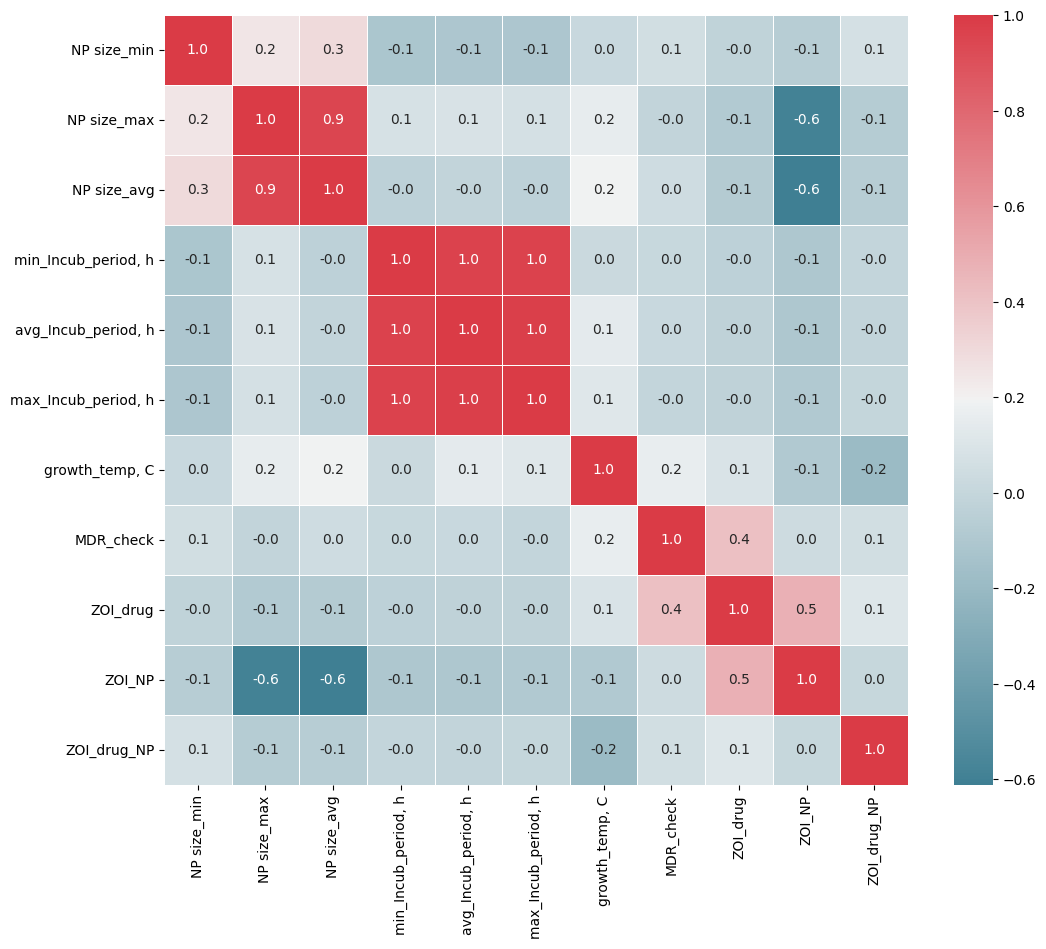

In [ ]:
corr = data.corr()
f, ax = plt.subplots(figsize=(12, 10)) #создание графика и определение его размеров
cmap = sns.diverging_palette(220, 10, as_cmap=True) #создание палитры для корреляционного графика
sns.heatmap(corr,cmap=cmap, linewidths=.5, annot=True, fmt=".1f")

In [ ]:
#Дропнем коррелирующие признаки
data = data.drop(['max_Incub_period, h', 'min_Incub_period, h', 'NP size_max',], axis=1)


In [ ]:
#Заменим строки на инты по следующей схеме
data.loc[:, ['NP_Synthesis',	'shape', 'genus']] = names_to_class(data.loc[:, ['NP_Synthesis',	'shape', 'genus']])

NP_Synthesis
                                                    0
0                    chem_synthesis by silver nitrate
1               chem_synthesis_reduction_by_D_maltose
2                    green_synthesis  by Bacillus sp.
3           green_synthesis  using fungus Trichoderma
4            green_synthesis by Klebsiella pneumoniae
5     green_synthesis from fungus  Aspergillus flavus
6   green_synthesis from fungus  Phytophthora infe...
7      green_synthesis from fungus Trichoderma viride
8   green_synthesis using C. zylinicum aqueous ext...
9   green_synthesis using Dioscorea bulbifera tube...
10               green_synthesis using Ulva fasciata 
11  green_synthesis using Withania coagulans fruit...
12  green_synthesis using extract of Klebsiella pn...
13  green_synthesis using extract of acinetobacter...
14       green_synthesis using extract of corn leaves
shape
                        0
0  nanorods and triangles
1               spherical
genus
                   0
0      Acine

На данном графике можно увидеть сильную корелляцию между такими параметрами, как: NP size_max, NP size_avg, min_incub_period, avg_incub_period, max_incub_period. Помимо этого, замечена обратная корреляция между ZOI_NP от таким параметров, как NP size_max и NP size_avg. Часть фич мы можем игнорировать при обучении моделей.

Функции для анализа и визуализации моделей

In [ ]:
#График по случайной выборке
def model_with_plot(dataset, rg):

    x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.iloc[:, :-1], dataset.iloc[:, -1], test_size=0.3)
    rg.fit(x_train, y_train)
    rmse = (sklearn.metrics.mean_squared_error(rg.predict(x_test), y_test)**0.5).astype(float).round(3)
    r2 = (sklearn.metrics.r2_score(rg.predict(x_test), y_test)**0.5).astype(float).round(3)
    plt.title('RMSE = '+str(rmse)+', R2 = '+str(r2))
    plt.xlabel('experimental')
    plt.ylabel('predicted')
    plt.ylim(0, 50)
    plt.xlim(0, 50)
    plt.show(plt.plot(rg.predict(x_test), y_test, 'ro'),  plt.plot([0, 50], [0, 50]))

In [ ]:
#Вывести общий R2 на трейне всего датасета и график feature importance
def feature_stats(dataset, rg):

  rg = sklearn.tree.DecisionTreeRegressor()
  rg.fit(dataset.iloc[:, :-1], dataset.iloc[:, -1])
  print('R2 на трейне', sklearn.metrics.r2_score(dataset.iloc[:, -1], rg.predict(dataset.iloc[:, :-1])))

  explainer = shap.TreeExplainer(rg) #(для моделей основанных на деревьях)
  shap_values = explainer(dataset.iloc[:, :-1])

  shap.summary_plot(shap_values, dataset.iloc[:, :-1], plot_type='bar')

In [ ]:
#Рассмотреть точность модели после удаления одного из дескрипторов
def r2_after_del(dataset, rg):
  c_dataset = dataset
  for i in np.array(c_dataset.iloc[:, :-1].columns):
    c_dataset = dataset
    c_dataset = c_dataset.drop([i], axis=1)
    rg.fit(c_dataset.iloc[:, :-1], c_dataset.iloc[:, -1])
    r_2 = sklearn.metrics.r2_score(c_dataset.iloc[:, -1], rg.predict(c_dataset.iloc[:, :-1]))
    print(i, r_2)

In [ ]:
#Рассмотреть точность модели после добавления одного из дескрипторов (descriptors - датафрейм из дескрипторов для молекул с той же нумерацией)
def append_desc_check(dataset, descriptors, rg):
  c_dataset = dataset
  history = [0, 0]
  for i in np.array(descriptors.iloc[:, 1:].columns):
    c_dataset = dataset.iloc[:, :-1]
    c_dataset.loc[:, 'desc'] = descriptors.loc[:, i]
    c_dataset.loc[:, 'ZOI_drug_NP'] = dataset.loc[:, 'ZOI_drug_NP'].dropna()

    rg.fit(c_dataset.iloc[:, :-1], c_dataset.iloc[:, -1])
    r_2 = sklearn.metrics.r2_score(c_dataset.iloc[:, -1], rg.predict(c_dataset.iloc[:, :-1]))
    if r_2 > history[1]: #Каждый последующий должен сильнее повышать точность
      history = [i, r_2]
      print(history)

In [ ]:
#Сравнить работу разных моделей на конкретном датасете
def model_deifference(dataset):
  x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.iloc[:, :-1], dataset.iloc[:, -1], test_size=0.3)
  reg = lazypredict.Supervised.LazyRegressor(verbose=0,
                                             ignore_warnings=False,
                                             custom_metric=False)
  models, predictions = reg.fit(x_train, x_test, y_train, y_test)
  return models

Работаем с химическими дескрипторами

In [ ]:
def normalize(dataset): #Нормализация датасета (только признаков)
    dataset.iloc[:, :-1] = (dataset.iloc[:, :-1]-dataset.iloc[:, :-1].mean ())/dataset.iloc[:, :-1].std()
    return dataset

def getMolDescriptors(mol, missingVal=None): #Рассчет дескрипторов для одной молекулы

    res = {}
    for nm,fn in Descriptors._descList:

        try:
            val = fn(mol)
        except:

            import traceback
            traceback.print_exc()

            val = missingVal
        res[nm] = val
    return res


def data_desc(dataset): #Рассчитать все rdkit дескрипторы для колонки 'SMILES' из датафрейма
  dataset.index = np.array(range(len(dataset.loc[:, 'smiles'])))
  descriptors = pd.DataFrame([getMolDescriptors(Chem.MolFromSmiles(data.iloc[0, :]['smiles']))]).T
  for mol in dataset.loc[1:, 'smiles']:

    d = pd.DataFrame([getMolDescriptors(Chem.MolFromSmiles(mol))]).T
    descriptors = pd.concat([descriptors, d], axis = 1)

  return descriptors.T

In [ ]:
#Считаем ВСЕ дескрипторы для всех молекул антибиотика
descriptors = data_desc(data)
descriptors = normalize(descriptors) #нормализация
descriptors = descriptors.dropna(axis=1) #убираем неудачано рассчитаные дескрипторы
descriptors.index = data.index

In [ ]:
#Функция рассчитывает качество ПРЕДСКАЗАНИЯ модели на основе случайно выбранных по номеру rdkit дескрипторов из датафрейма descriptors
def RMSE_score(individual):
   global descriptors
   global data
   dataset = pd.concat([descriptors.iloc[:, individual], data.drop(['smiles'], axis=1)], axis=1)
   x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.iloc[:, :-1], dataset.iloc[:, -1], test_size=0.3)
   rg = sklearn.ensemble.GradientBoostingRegressor()#sklearn.tree.DecisionTreeRegressor()
   rg.fit(x_train, y_train)
   return list(descriptors.iloc[:, individual].columns), (sklearn.metrics.mean_squared_error(rg.predict(x_test), y_test)**0.5).astype(float), sklearn.metrics.r2_score(rg.predict(x_test), y_test)

#Реализован подбор дескрипторов, с каждым последующим дескриптором качесвто модели улучшается (RMSE становится ниже)
num_descs = 9 #Число дескрипторов
len_of_population = 3000 #Популяция дескрипторов
history = [0, 8]
population = [np.array([(np.random.choice(np.array(range(0, 167)))) for i in range(num_descs)]) for j in range(len_of_population)]
for i in population:
  test = []
  r2_test = []
  for j in range(20):
    test.append(RMSE_score(i)[1])
    r2_test.append(RMSE_score(i)[2])
    #print(np.mean(test))
  if np.mean(test) < history[1]:
    test_description = [list(descriptors.iloc[:, i].columns), np.mean(test), np.mean(r2_test)]
    history = test_description
    print((test_description))



[['ExactMolWt', 'fr_phenol_noOrthoHbond', 'Chi1', 'PEOE_VSA12', 'VSA_EState6', 'NumAliphaticRings', 'fr_NH1', 'EState_VSA8', 'Kappa1'], 4.856344233220254, 0.6932990090644366]
[['MaxAbsEStateIndex', 'MolMR', 'FractionCSP3', 'fr_NH1', 'fr_imide', 'EState_VSA7', 'MolLogP', 'EState_VSA8', 'RingCount'], 4.790275745655155, 0.6772831055140563]
[['RingCount', 'fr_nitro_arom', 'NHOHCount', 'fr_unbrch_alkane', 'PEOE_VSA2', 'fr_NH0', 'fr_Al_COO', 'VSA_EState2', 'MinEStateIndex'], 4.747922598347879, 0.7195842575927369]
[['fr_C_O_noCOO', 'NumHeteroatoms', 'PEOE_VSA9', 'SlogP_VSA12', 'FpDensityMorgan1', 'HallKierAlpha', 'MaxAbsPartialCharge', 'MolMR', 'NumAliphaticCarbocycles'], 4.706203959901202, 0.7023165966495312]
[['fr_quatN', 'fr_C_O_noCOO', 'FpDensityMorgan2', 'FpDensityMorgan3', 'SlogP_VSA2', 'PEOE_VSA6', 'fr_urea', 'FpDensityMorgan2', 'VSA_EState9'], 4.6971157702193995, 0.7069261374781506]
[['MolWt', 'SMR_VSA6', 'Chi1n', 'fr_oxime', 'FractionCSP3', 'VSA_EState7', 'Kappa3', 'EState_VSA2', 'Nu

KeyboardInterrupt: ignored

Проанализируем модель

In [ ]:
#Прибавим найденные дескрипторы к общему датасету и выкинуть smiles
best_descriptors = ['FpDensityMorgan1', 'fr_C_O_noCOO', 'fr_Al_COO', 'EState_VSA7', 'fr_COO', 'fr_nitro_arom', 'SlogP_VSA2', 'SlogP_VSA10', 'LabuteASA']
dataset = pd.concat([descriptors.loc[:, best_descriptors], data.drop(['smiles'], axis=1)], axis=1)

In [ ]:
model_deifference(dataset) #Может не сработать с первого раза (Прожать несколько раз)

100%|██████████| 42/42 [00:06<00:00,  6.95it/s]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LGBMRegressor,0.72,0.75,4.68,0.06
HistGradientBoostingRegressor,0.71,0.75,4.75,0.26
GradientBoostingRegressor,0.69,0.72,4.97,0.22
ExtraTreesRegressor,0.67,0.71,5.08,0.26
BaggingRegressor,0.64,0.68,5.32,0.06
RandomForestRegressor,0.63,0.68,5.36,0.36
XGBRegressor,0.59,0.64,5.69,0.12
DecisionTreeRegressor,0.48,0.54,6.37,0.03
ExtraTreeRegressor,0.44,0.51,6.61,0.03


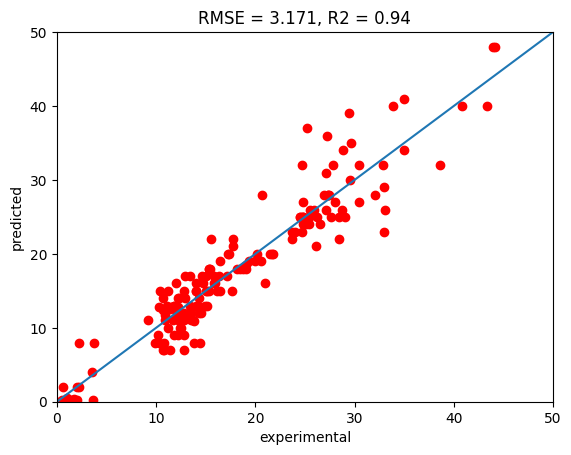

In [ ]:
#В топе предыдущей команды почти всегда был GradientBoostingRegressor, поэтому будет использовать для анализа именно его
model_with_plot(dataset, sklearn.ensemble.GradientBoostingRegressor())

R2 на трейне 0.9714087499086147


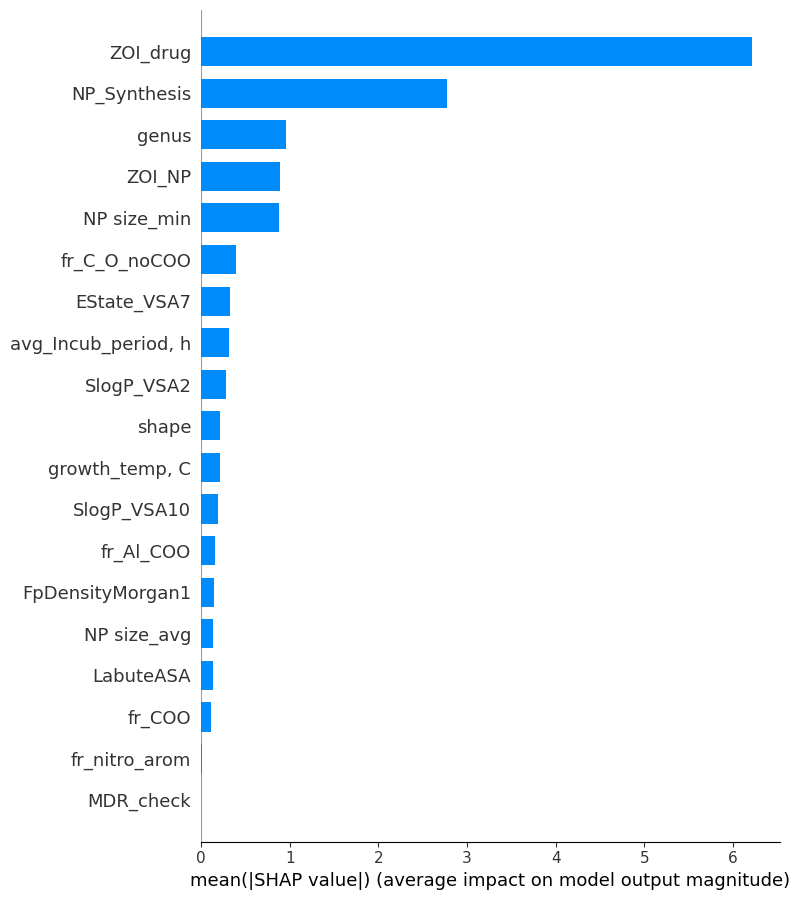

In [ ]:
feature_stats(dataset, sklearn.ensemble.GradientBoostingRegressor())
#Видим что несколько дескрипторов почти не участвуют в модели (далее выбросим их)

In [ ]:
r2_after_del(dataset)

FpDensityMorgan1 0.8866243337163227
fr_C_O_noCOO 0.885966566459803
fr_Al_COO 0.8880017148883711
EState_VSA7 0.8879214206106812
fr_COO 0.8900781418553552
fr_nitro_arom 0.8893012905917745
SlogP_VSA2 0.8888861812809566
SlogP_VSA10 0.8897252936145855
LabuteASA 0.8858132634727182
genus 0.8790707658851337
NP_Synthesis 0.8905258312467026
shape 0.8901071905837132
NP size_min 0.8858404196748432
NP size_avg 0.8887929673226921
avg_Incub_period, h 0.8862817978319231
growth_temp, C 0.8887651642160106
MDR_check 0.8880097915524968
ZOI_drug 0.719768159013062
ZOI_NP 0.8916635001859362


In [ ]:
append_desc_check(dataset, descriptors, sklearn.ensemble.GradientBoostingRegressor())

['MaxEStateIndex', 0.8921760854586736]
['AvgIpc', 0.8946707333681968]


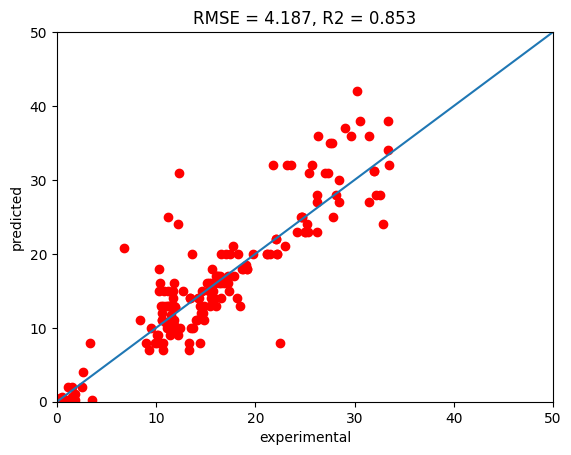

In [ ]:
#Выбросим ненужные фичи и пострим график
dataset = dataset.drop(['fr_nitro_arom', 'MDR_check'], axis=1)
model_with_plot(dataset, sklearn.ensemble.GradientBoostingRegressor())

In [ ]:
#Выполним кросс-валидацию модели

dataset = shuffle(dataset) #Перемешаем датасет т.к ZOI_drug_NP в датасете идет последовательно и поэтому модель не будет нормально работать из за этого
rg = sklearn.ensemble.GradientBoostingRegressor()
cross_val = cross_validate(rg, dataset.iloc[:, :-1], dataset.iloc[:, -1], cv=5, scoring=['r2', 'neg_mean_absolute_percentage_error'])
print('Средний R2 при проведении кросс-валидации = ', np.mean(cross_val['test_r2']))
pd.DataFrame(cross_val)


Средний R2 при проведении кросс-валидации =  0.743263432461759


,fit_time,score_time,test_r2,test_neg_mean_absolute_percentage_error
0,0.13,0.00,0.69,-0.30
1,0.12,0.00,0.81,-0.72
2,0.16,0.00,0.75,-1.10
3,0.17,0.00,0.88,-1.16
4,0.16,0.00,0.59,-0.67


MORDRED дескрипторы

In [ ]:
#Считать (долго)
mols = [Chem.MolFromSmiles(i) for i in data['smiles']]

    # Create Calculator
calc = Calculator(descriptors)

    # map method calculate multiple molecules (return generator)
print(list(calc.map(mols)))

    # pandas method calculate multiple molecules (return pandas DataFrame)
mordred_descriptors = pd.DataFrame(calc.pandas(mols))

mordred_descriptors.to_csv(r'/content/mordred_descriptors.csv')

  1%|          | 5/550 [00:20<41:04,  4.52s/it]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  5%|▍         | 26/550 [00:54<17:07,  1.96s/it]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 550/550 [11:16<00:00,  1.23s/it]
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  1%|          | 5/550 [00:12<23:54,  2.63s/it]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 12%|█▏        | 64/550 [01:08<15:27,  1.91s/it]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 550/550 [10:28<00:00,  1.14s/it]


In [ ]:
#Подгрузить посчитанные <3
mordred_descriptors = pd.read_csv(r'/content/mordred_descriptors.csv')
mordred_descriptors = mordred_descriptors[~(mordred_descriptors == mordred_descriptors.astype(str))].dropna(axis=1, how='all') #Удалим дескрипторы рассчитанные с ошибкой
mordred_descriptors = mordred_descriptors.dropna(axis=1, how='any')                                                            #
mordred_descriptors.index = data.index
datasetM.loc[:, data.drop(['smiles'], axis=1).columns] = data.drop(['smiles'], axis=1)
mordred_descriptors = mordred_descriptors.drop(['Unnamed: 0'], axis=1)


In [ ]:
import seaborn as sns

[['JGT10', 'ATS7dv', 'SMR_VSA4', 'NtCH'], 5.0905226720817796, 0.6579584799202691]


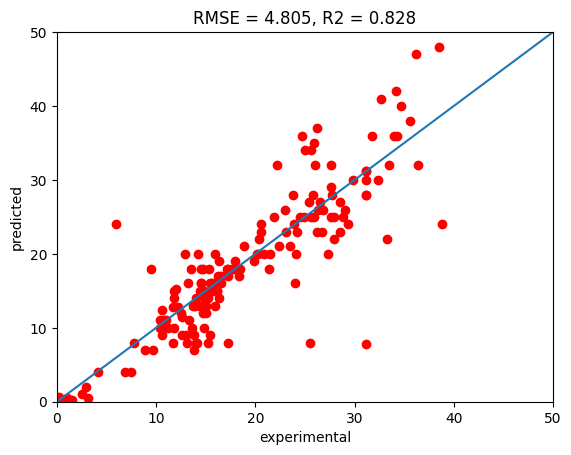

[['n12HRing', 'AATSC3m', 'PEOE_VSA13', 'AATSC0m'], 4.797325764534523, 0.6349043288767531]


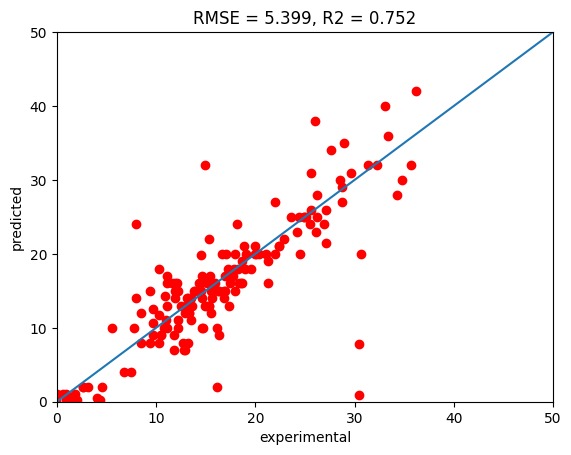

[['SRW10', 'n12FAHRing', 'AATS0pe', 'GATS8c'], 4.527854374860885, 0.7082990227218497]


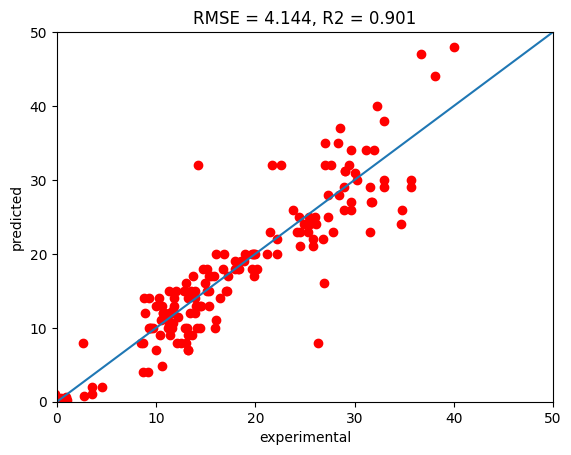

[['GATS8Z', 'AATS6p', 'n5FaRing', 'AATSC8d'], 4.466900828275876, 0.690234444328768]


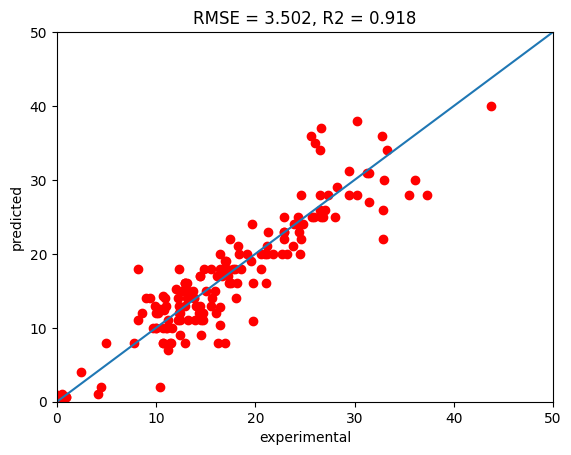

[['NsCl', 'ATSC2pe', 'n9FHRing', 'n4aRing'], 4.26007222666764, 0.6710221818351589]


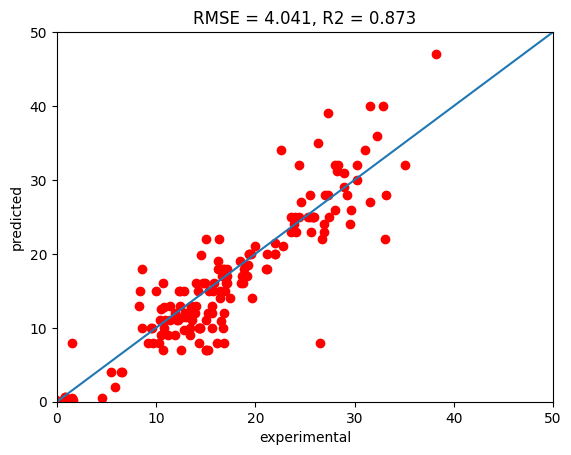

In [ ]:
#Реализован подбор дескрипторов, с каждым последующим дескриптором качесвто модели улучшается (RMSE становится ниже)

#Функция рассчитывает качество ПРЕДСКАЗАНИЯ модели на основе случайно выбранных по номеру rdkit дескрипторов из датафрейма descriptors
def RMSE_score(individual):
   global mordred_descriptors
   global data
   dataset = pd.concat([mordred_descriptors.iloc[:, individual], data.drop(['smiles'], axis=1)], axis=1)
   x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.iloc[:, :-1], dataset.iloc[:, -1], test_size=0.3)
   rg = sklearn.ensemble.HistGradientBoostingRegressor()#sklearn.linear_model.Ridge(alpha=0.1)
   rg.fit(x_train, y_train)
   return list(mordred_descriptors.iloc[:, individual].columns), (sklearn.metrics.mean_squared_error(rg.predict(x_test), y_test)**0.5).astype(float), sklearn.metrics.r2_score(rg.predict(x_test), y_test)

num_descs = 4 #Число дескрипторов
len_of_population = 5000 #Популяция дескрипторов
history = [0, 8]
population = [np.array([(np.random.choice(np.array(range(0, 1165)))) for i in range(num_descs)]) for j in range(len_of_population)]
for i in population:
  test = []
  r2_test = []
  for j in range(20): #Каждый прогон по 20 итераций чтобы уйти от рандома усреднением результата
    test.append(RMSE_score(i)[1])
    r2_test.append(RMSE_score(i)[2])
    #print(np.mean(test))
  if np.mean(test) < history[1]:
    test_description = [list(mordred_descriptors.iloc[:, i].columns), np.mean(test), np.mean(r2_test)]
    history = test_description
    print((test_description))


    #График по случайной выборке
    iter_dataset = pd.concat([mordred_descriptors.iloc[:, i], data.drop(['smiles'], axis=1)], axis=1)

    x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(iter_dataset.iloc[:, :-1], iter_dataset.iloc[:, -1], test_size=0.3)
    rg = sklearn.ensemble.HistGradientBoostingRegressor()
    rg.fit(x_train, y_train)
    rmse = (sklearn.metrics.mean_squared_error(rg.predict(x_test), y_test)**0.5).astype(float).round(3)
    r2 = (sklearn.metrics.r2_score(rg.predict(x_test), y_test)**0.5).astype(float).round(3)
    plt.title('RMSE = '+str(rmse)+', R2 = '+str(r2))
    plt.xlabel('experimental')
    plt.ylabel('predicted')
    plt.ylim(0, 50)
    plt.xlim(0, 50)
    plt.show(plt.plot(rg.predict(x_test), y_test, 'ro'),  plt.plot([0, 50], [0, 50]))


In [ ]:
#['NsCl', 'ATSC2pe', 'n9FHRing', 'n4aRing']

Генетический алгоритм подбора фичей

In [ ]:
datasetM = pd.concat([mordred_descriptors, data.drop(['smiles'], axis=1)], axis=1)
#datasetM = datasetM.dropna(axis=1, how='any')

In [ ]:
X = datasetM.iloc[:, :-1]
y = datasetM.iloc[:, -1]

estimator = DecisionTreeRegressor()
model = GeneticSelectionCV(
    estimator, cv=5, verbose=3,
    scoring="neg_mean_squared_error", max_features=20,
    n_population=300, crossover_proba=0.5,
    mutation_proba=0.2, n_generations=50,
    crossover_independent_proba=0.5,
    mutation_independent_proba=0.1,
    tournament_size=3, n_gen_no_change=10,
    caching=True, n_jobs=-1)
model = model.fit(X, y)
print('Features:', X.columns[model.support_])


Selecting features with genetic algorithm.
gen	nevals	avg                                  	std                               	min                                  	max                                  
0  	300   	[-152.883937   10.916667  139.002744]	[ 11.068707   5.94332    8.183386]	[-214.344509    1.        112.811407]	[-140.63796    20.        175.408985]
1  	173   	[-2085.793068    30.843333  2076.081072]	[ 3915.840772    41.432099  3920.64665 ]	[-10000.            1.          126.280745]	[ -139.176241   137.       10000.      ]
2  	170   	[-2446.431528    33.24      2437.160939]	[ 4167.133003    42.964044  4172.247898]	[-10000.            1.          125.358237]	[ -138.358736   134.       10000.      ]
3  	165   	[-2117.640918    30.56      2108.13908 ]	[ 3941.18066     42.203472  3945.932419]	[-10000.            1.          125.358237]	[ -138.358736   163.       10000.      ]
4  	168   	[-2215.658236    30.593333  2206.318149]	[ 4013.452202    42.175917  4018.268802]	[-10000.  

In [ ]:
#Формируем датасет на основе оптимизированных фичей

test_dataset = datasetM.loc[:, ['nBondsO', 'C3SP2', 'SlogP_VSA8', 'SRW04', 'Xch-7d', 'ZOI_drug', 'ZOI_drug_NP']]
test_dataset.index = data.index
testing_dataset = pd.concat([data.loc[:, ['genus', 'avg_Incub_period, h', 'growth_temp, C', 'ZOI_NP']], test_dataset], axis=1) #присоеденим столбцы дающие информацию о бактерии

In [ ]:
testing_dataset

,genus,"avg_Incub_period, h","growth_temp, C",ZOI_NP,nBondsO,C3SP2,SlogP_VSA8,SRW04,Xch-7d,ZOI_drug,ZOI_drug_NP
0,6,84.00,37.00,27.17,27,1,0.00,5.44,1.61,32.00,32.00
1,6,84.00,37.00,27.17,25,1,0.00,5.35,1.55,32.00,32.00
2,6,84.00,37.00,19.18,27,1,0.00,5.44,1.61,32.00,32.00
3,6,84.00,37.00,19.18,25,1,0.00,5.35,1.55,32.00,32.00
4,10,288.00,30.00,16.04,110,7,11.13,6.78,1.20,0.00,18.00
...,...,...,...,...,...,...,...,...,...,...,...
545,13,18.00,37.00,27.17,27,1,0.00,5.44,1.61,0.25,0.12
546,18,36.00,37.00,27.17,25,1,0.00,5.35,1.55,1.00,0.12
547,15,48.00,37.00,5.33,36,1,0.00,5.58,0.93,0.31,0.10
548,13,18.00,37.00,27.17,25,1,0.00,5.35,1.55,0.03,0.03


In [ ]:
model_deifference(testing_dataset) #прожать несколько раз (не работает с перовго раза)

100%|██████████| 42/42 [00:07<00:00,  5.30it/s]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,0.72,0.74,4.99,0.20
GradientBoostingRegressor,0.71,0.73,5.07,0.15
XGBRegressor,0.71,0.73,5.10,0.09
HistGradientBoostingRegressor,0.69,0.70,5.33,0.23
RandomForestRegressor,0.67,0.69,5.43,0.29
LGBMRegressor,0.66,0.68,5.52,0.06
BaggingRegressor,0.65,0.67,5.63,0.05
DecisionTreeRegressor,0.54,0.56,6.47,0.02
ExtraTreeRegressor,0.52,0.55,6.56,0.03


In [ ]:
r2_after_del(testing_dataset)

genus 0.872297192359498
avg_Incub_period, h 0.892597721110206
growth_temp, C 0.8889803448152498
ZOI_NP 0.8526557659030605
nBondsO 0.8919078453184011
C3SP2 0.8910496136454796
SlogP_VSA8 0.8888559157758372
SRW04 0.8894265574012291
Xch-7d 0.8864776676514986
ZOI_drug 0.7056675923964264


In [ ]:
append_desc_check(testing_dataset, mordred_descriptors, sklearn.ensemble.ExtraTreesRegressor())

R2 на трейне 0.9714087499086147


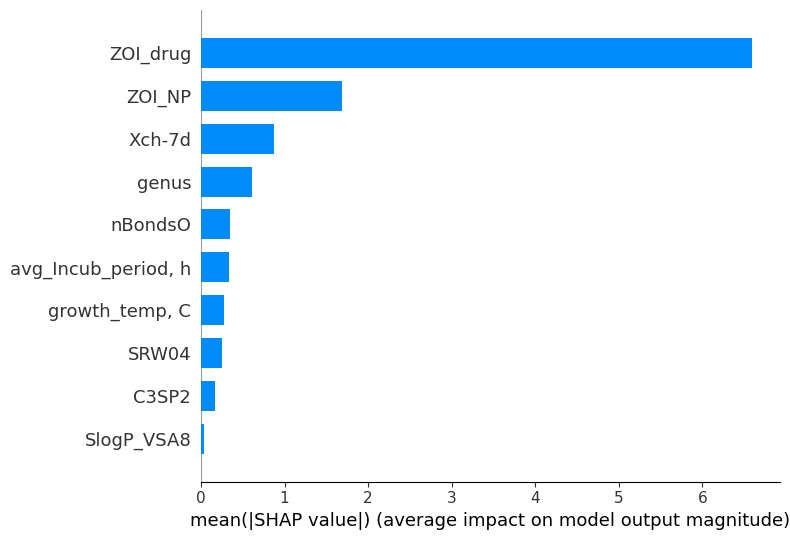

In [ ]:
feature_stats(testing_dataset, sklearn.ensemble.ExtraTreesRegressor())

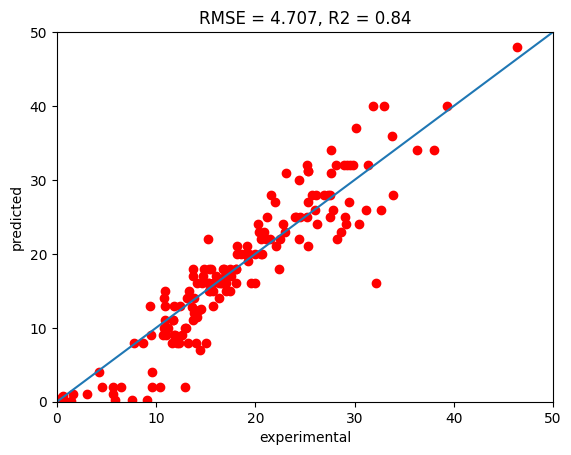

In [ ]:
model_with_plot(testing_dataset, sklearn.ensemble.ExtraTreesRegressor(max_depth=12))

In [ ]:
#Выполним кросс-валидацию модели

testing_dataset = shuffle(testing_dataset) #Перемешаем датасет т.к ZOI_drug_NP в датасете идет последовательно и поэтому модель не будет нормально работать из за этого
rg = sklearn.ensemble.ExtraTreesRegressor(max_depth=12)
cross_val = cross_validate(rg, testing_dataset.iloc[:, :-1], testing_dataset.iloc[:, -1], cv=5, scoring=['r2', 'neg_mean_absolute_percentage_error'])
print('Средний R2 при проведении кросс-валидации = ', np.mean(cross_val['test_r2']))
pd.DataFrame(cross_val)


Средний R2 при проведении кросс-валидации =  0.7490551294825011


,fit_time,score_time,test_r2,test_neg_mean_absolute_percentage_error
0,0.28,0.02,0.80,-0.43
1,0.28,0.02,0.65,-0.47
2,0.25,0.02,0.73,-4.34
3,0.27,0.02,0.82,-0.53
4,0.28,0.02,0.74,-0.81


Посторим модель на основе многослойного перцептрона

In [ ]:
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [ ]:
#Поработаем с датасетом с дескрипторами rdkit
dataset = normalize(dataset)

In [ ]:
def Neural_net(dataset):
  dataset = dataset.astype(float)
  x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.iloc[:, :-1], dataset.iloc[:, -1], test_size=0.3)

  model = Sequential([

    Dense(units=1, input_shape=(x_train.shape[1],)),
    Dense(2048, activation='relu'),
    Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    Dense(8),
    Dense(1)

  ])

  model.compile(
  loss=rmse,
  optimizer=Adam(),
  metrics=[rmse],
    )

  model.fit(x_train, y_train, epochs=200, verbose = 1)
  model.evaluate(x_test, y_test, batch_size=200)

  r2_test = sklearn.metrics.r2_score(y_test, model.predict(x_test, verbose = 0)).round(3)
  r2_train = sklearn.metrics.r2_score(y_train, model.predict(x_train, verbose = 0)).round(3)

  res_test = pd.DataFrame([model.predict(x_test, verbose = 0).T[0], y_test.values])
  res_train = pd.DataFrame([model.predict(x_train, verbose = 0).T[0], y_train.values])

  plt.ylim(0, 50)
  plt.xlim(0, 50)
  plt.title('R2 train = '+str(r2_train)+ 'R2 test = '+str(r2_test))
  plt.show([plt.plot([0, 50], [0, 50]), plt.plot(res_train.iloc[1, :], res_train.iloc[0, :], 'ro', color='b'), plt.plot(res_test.iloc[1, :], res_test.iloc[0, :], 'ro')])




Epoch 1/200
13/13 [==============================] - 5s 92ms/step - loss: 17.4853 - rmse: 16.2827
Epoch 2/200
13/13 [==============================] - 2s 117ms/step - loss: 13.2496 - rmse: 13.7096
Epoch 3/200
13/13 [==============================] - 1s 109ms/step - loss: 11.5314 - rmse: 11.4494
Epoch 4/200
13/13 [==============================] - 2s 123ms/step - loss: 11.6653 - rmse: 12.0816
Epoch 5/200
13/13 [==============================] - 2s 127ms/step - loss: 10.5190 - rmse: 10.6953
Epoch 6/200
13/13 [==============================] - 2s 168ms/step - loss: 10.9960 - rmse: 10.3766
Epoch 7/200
13/13 [==============================] - 2s 162ms/step - loss: 10.4906 - rmse: 10.4007
Epoch 8/200
13/13 [==============================] - 1s 112ms/step - loss: 10.2888 - rmse: 9.6428
Epoch 9/200
13/13 [==============================] - 1s 94ms/step - loss: 9.9984 - rmse: 9.5578
Epoch 10/200
13/13 [==============================] - 1s 95ms/step - loss: 10.2857 - rmse: 9.8224
Epoch 11/200
13/

1/1 [==============================] - 0s 205ms/step - loss: 8.8919 - rmse: 8.8919


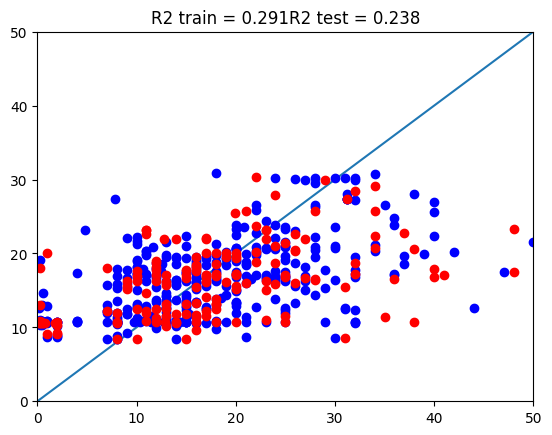

In [ ]:
Neural_net(dataset)

Epoch 1/200
13/13 [==============================] - 3s 63ms/step - loss: 180638240.0000 - rmse: 167177312.0000
Epoch 2/200
13/13 [==============================] - 1s 63ms/step - loss: 86039968.0000 - rmse: 79628336.0000
Epoch 3/200
13/13 [==============================] - 1s 64ms/step - loss: 26387280.0000 - rmse: 24420962.0000
Epoch 4/200
13/13 [==============================] - 1s 61ms/step - loss: 26685264.0000 - rmse: 24696704.0000
Epoch 5/200
13/13 [==============================] - 1s 80ms/step - loss: 14875867.0000 - rmse: 13767339.0000
Epoch 6/200
13/13 [==============================] - 1s 69ms/step - loss: 3209445.5000 - rmse: 2970287.5000
Epoch 7/200
13/13 [==============================] - 1s 68ms/step - loss: 2468056.2500 - rmse: 2467974.7500
Epoch 8/200
13/13 [==============================] - 1s 76ms/step - loss: 1714165.7500 - rmse: 1586435.8750
Epoch 9/200
13/13 [==============================] - 1s 67ms/step - loss: 1179989.3750 - rmse: 1092070.3750
Epoch 10/200
13/

1/1 [==============================] - 0s 229ms/step - loss: 6.2810 - rmse: 6.2810


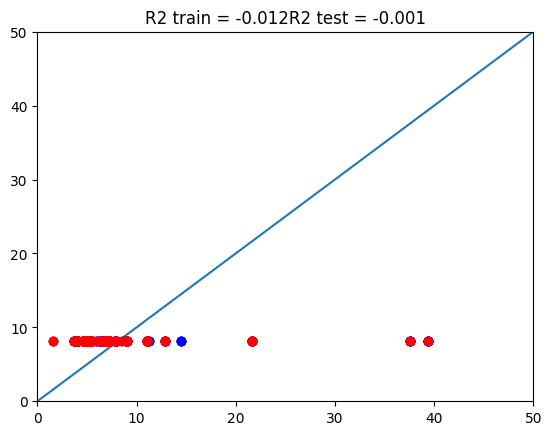

In [ ]:
Neural_net(mordred_descriptors)